# XPCS Pipeline for GiSAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [ ]:
from chxanalys.chx_libs import (np, roi, time, datetime, os, get_events, 
                                getpass, db, get_images,LogNorm, plt,tqdm, utils, Model,
                              multi_tau_lags)

from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames,  
     load_data, load_mask,get_fields, reverse_updown, ring_edges,get_avg_img,check_shutter_open,
    apply_mask, show_img,check_ROI_intensity,run_time, plot1D, get_each_frame_intensity,                                             
    create_hot_pixel_mask,show_ROI_on_image,create_time_slice,save_lists, 
                        save_arrays, psave_obj,pload_obj, get_non_uniform_edges )
 

from chxanalys.XPCS_SAXS import (get_circular_average,save_lists,get_ring_mask, get_each_ring_mean_intensity,
                                 plot_qIq_with_ROI,save_saxs_g2,plot_saxs_g2,fit_saxs_g2,cal_g2,
                                create_hot_pixel_mask,get_circular_average,get_t_iq,save_saxs_g2,
                                plot_saxs_g2,fit_saxs_g2,fit_q2_rate,plot_saxs_two_g2,fit_q_rate,
                                circular_average,plot_saxs_g4, get_t_iqc,multi_uids_saxs_xpcs_analysis,
                                 save_g2)


from chxanalys.Two_Time_Correlation_Function import (show_C12, get_one_time_from_two_time,
                                                get_four_time_from_two_time,rotate_g12q_to_rectangle)
from chxanalys.chx_compress import (combine_binary_files,
                           segment_compress_eigerdata,     create_compress_header,            
                            para_segment_compress_eigerdata,para_compress_eigerdata)

from chxanalys.chx_compress_analysis import ( compress_eigerdata, read_compressed_eigerdata,
                                             Multifile,get_avg_imgc, get_each_frame_intensityc,
                get_each_ring_mean_intensityc, mean_intensityc,cal_waterfallc,plot_waterfallc,  
)

from chxanalys.SAXS import fit_form_factor
from chxanalys.chx_correlationc import ( cal_g2c,Get_Pixel_Arrayc,auto_two_Arrayc,get_pixelist_interp_iq,)
from chxanalys.chx_correlationp import (cal_g2p, auto_two_Arrayp)

from chxanalys.Create_Report import (create_pdf_report, 
                                create_multi_pdf_reports_for_uids,create_one_pdf_reports_for_uids)


from chxanalys.XPCS_GiSAXS import (get_qedge,get_qmap_label,get_qr_tick_label, get_reflected_angles,
    convert_gisaxs_pixel_to_q, show_qzr_map, get_1d_qr, get_qzrmap, show_qzr_roi,get_each_box_mean_intensity,
    save_gisaxs_g2,plot_gisaxs_g2, fit_gisaxs_g2,plot_gisaxs_two_g2,plot_qr_1d_with_ROI,fit_qr_qz_rate,
                                  multi_uids_gisaxs_xpcs_analysis,plot_gisaxs_g4,
                                  get_t_qrc, plot_t_qrc)

%matplotlib notebook

In [ ]:
%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/XPCS_GiSAXS.py
%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/Create_Report.py
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/chx_compress.py

In [ ]:
#from chxtools.handlers import LazyEigerHandler
#db.fs.register_handler('AD_EIGER', LazyEigerHandler)

In [6]:

plt.rcParams.update({'figure.max_open_warning': 0})

In [7]:
#%reset

In [8]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [9]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /user/yuzhang/analysis/2016_3/pierce/XPCS_GiSAXS_Single_Run_Octo_BOX_ROI-DEV.ipynb


## Make a directory for saving results

In [10]:
CYCLE = '2016_3'

username = getpass.getuser()

username = 'pierce'

date_path = datetime.now().strftime('%Y/%m/%d')  # e.g., '2016/03/01'
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')



##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'


os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/pierce/Results/


## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines

In [11]:
#After fixing the "good_start"(bad start!) bug
uid = '7b9f59' #count : 1 ['7b9f59'] (scan num: 2989) (Measurement: cama3 1Hz 600frames hydrated DI water fresh spot )

uid = 'ccc44d' #count : 1 ['ccc44d'] (scan num: 3359) (Measurement: Ag test -.15V timeseries )
uid = 'e551e4' #count : 1 ['e551e4'] (scan num: 3373) (Measurement: Ag test 0.0V timescans )
uid = 'd0ba23' #count : 1 ['d0ba23'] (scan num: 3375) (Measurement: Ag test 0.0V timescans 0.2 )
uid = 'ab2c60' #count : 1 ['ab2c60'] (scan num: 3376) (Measurement: Ag test -.15V timescans 0.2 )
uid = 'c5ad97' #count : 1 ['c5ad97'] (scan num: 3377) (Measurement: Ag test .2V timescans 0.2 )
uid = '68b94b' #count : 1 ['68b94b'] (scan num: 3378) (Measurement: Ag test .2V timescans 0.5 )
uid = 'f65e78' #count : 1 ['f65e78'] (scan num: 3379) (Measurement: Ag test .3V timescans 0.5 )
uid = 'cf86f8' #count : 1 ['cf86f8'] (scan num: 3380) (Measurement: Ag test .4V timescans 0.5 )
uid = '159bdf' #count : 1 ['159bdf'] (scan num: 3385) (Measurement: Ag test .2V timescans 0.5 after desorb )
uid = '68954e' #count : 1 ['68954e'] (scan num: 3399) (Measurement: Ag test Open Circuit 0.5 sec )
uid = 'beead8' #count : 1 ['beead8'] (scan num: 3400) (Measurement: Ag test Open Circuit 0.25 sec )'
uid = '223dfc' #count : 1 ['223dfc'] (scan num: 3401) (Measurement: Ag test Open Circuit 0.25 sec )
uid = '43645c' #count : 1 ['43645c'] (scan num: 3412) (Measurement: Ag Open Circuit to 0.2, 0.5sec )
uid = '7d9677' #count : 1 ['7d9677'] (scan num: 3413) (Measurement: Ag 0.2 0.0V 0.5sec )
uid = '287d8d' #count : 1 ['287d8d'] (scan num: 3414) (Measurement: Ag 0.0V -.1V 0.5sec )
uid = '29c684' #count : 1 ['29c684'] (scan num: 3432) (Measurement: Ag hold -.15V 0.5sec )
uid = '4cea80' #count : 1 ['4cea80'] (scan num: 3473) (Measurement: Ag -0.15V timeseries 0.5sec )
uid = '4d7e23' #count : 1 ['4d7e23'] (scan num: 3474) (Measurement: Ag -0.15V timeseries 0.5sec )

uid = 'ee3139' #count : 1 ['ee3139'] (scan num: 3543) (Measurement: Ag Ultra Cube timescan 0.025sec )

uid = 'aaaeaa' #count : 1 ['aaaeaa'] (scan num: 3545) (Measurement: Ag Ultra Cube timescan 0.01sec )
uid = 'c60822' #count : 1 ['c60822'] (scan num: 3557) (Measurement: Ag Ultra Cube att0.1 0.0V 1.0sec )
uid = 'f30606' #count : 1 ['f30606'] (scan num: 3558) (Measurement: Ag Ultra Cube att0.2 0.0V 1.0sec )
uid = '10c2ce' #count : 1 ['10c2ce'] (scan num: 3542) (Measurement: Ag Ultra Cube )
uid = 'b80f49' #count : 1 ['b80f49'] (scan num: 3544) (Measurement: Ag Ultra Cube timescan 0.1sec )
uid = '6ecd2f' #count : 1 ['6ecd2f'] (scan num: 3559) (Measurement: Ag Ultra Cube att0.2 -.15V 1.0sec )
uid = '786129' #count : 1 ['786129'] (scan num: 3560) (Measurement: Ag Ultra Cube att0.2 -.15V 1.0sec )
uid = '0c3eb3' #count : 1 ['0c3eb3'] (scan num: 3571) (Measurement: Ag Ultra Cube att0.1 .2V 1.0sec new spot )
uid = 'c6ee86' #count : 1 ['c6ee86'] (scan num: 3572) (Measurement: Ag Ultra Cube att0.1 .3V 1.0sec new spot )
uid = 'e5120a' #count : 1 ['e5120a'] (scan num: 3573) (Measurement: Ag Ultra Cube att0.1 -.15V 1.0sec new spot )
#uid = '6abf7e' #count : 1 ['6abf7e'] (scan num: 3574) (Measurement: Ag Ultra Cube att0.1 -.1V 1.0sec new spot )
uid = '8308d1' #count : 1 ['8308d1'] (scan num: 3575) (Measurement: Ag Ultra Cube att0.1 -.05V 1.0sec new spot )
uid = '0c6da3' #count : 1 ['0c6da3'] (scan num: 3576) (Measurement: Ag Ultra Cube att0.1 0.0V 1.0sec new spot )
uid = '6f634b' #count : 1 ['6f634b'] (scan num: 3577) (Measurement: Ag Ultra Cube att0.1 0.5V 1.0sec new spot )
uid = '4d33f6' #count : 1 ['4d33f6'] (scan num: 3578) (Measurement: Ag Ultra Cube att0.1 0.1V 1.0sec new spot )
uid = '8b8c95' #count : 1 ['8b8c95'] (scan num: 3579) (Measurement: Ag Ultra Cube att0.1 0.15V 1.0sec new spot )
uid = 'c4a022' #count : 1 ['c4a022'] (scan num: 3580) (Measurement: Ag Ultra Cube att0.1 0.2V 1.0sec new spot )
uid = '81b95e' #count : 1 ['81b95e'] (scan num: 3581) (Measurement: Ag Ultra Cube att0.1 0.25V 1.0sec new spot )
uid = 'bc9249' #count : 1 ['bc9249'] (scan num: 3582) (Measurement: Ag Ultra Cube att0.1 0.3V 1.0sec new spot )
uid = '23171d' #count : 1 ['23171d'] (scan num: 3583) (Measurement: Ag Ultra Cube att0.1 0.0V 1.0sec new spot )
uid = '7eb376' #count : 1 ['7eb376'] (scan num: 3584) (Measurement: Ag Ultra Cube att0.1 0.3V 1.0sec new spot )
uid = '990893' #count : 1 ['990893'] (scan num: 3586) (Measurement: Ag Ultra Cube att0.1 0.3V 1.0sec new spot )
uid = '71962d' #count : 1 ['71962d'] (scan num: 3587) (Measurement: Ag Ultra Cube att0.1 0.2V 1.0sec new spot )
uid = '43a6ec' #count : 1 ['43a6ec'] (scan num: 3588) (Measurement: Ag Ultra Cube att0.1 0.1V 1.0sec new spot )
uid = '377a5b' #count : 1 ['377a5b'] (scan num: 3589) (Measurement: Ag Ultra Cube att0.1 0.0V 1.0sec new spot )
uid = '0fe02b' #count : 1 ['0fe02b'] (scan num: 3590) (Measurement: Ag Ultra Cube att0.1 -0.05V 1.0sec new spot )
uid = '0ef838' #count : 1 ['0ef838'] (scan num: 3591) (Measurement: Ag Ultra Cube att0.1 -0.1V 1.0sec new spot )
uid = 'a4b520' #count : 1 ['a4b520'] (scan num: 3592) (Measurement: Ag Ultra Cube att0.1 -0.15V 1.0sec new spot )
uid = 'c6a063' #count : 1 ['c6a063'] (scan num: 3593) (Measurement: Ag Ultra Cube att0.1 -0.2V 1.0sec new spot )
uid = 'dfad73' #count : 1 ['dfad73'] (scan num: 3594) (Measurement: Ag Ultra Cube att0.1 -0.25V 1.0sec new spot )
uid = 'f5ff18' #count : 1 ['f5ff18'] (scan num: 3595) (Measurement: Ag Ultra Cube att0.1 .3V 1.0sec new spot )
uid = '527766' #count : 1 ['527766'] (scan num: 3596) (Measurement: Ag Ultra Cube att0.1 .35V 1.0sec new spot )
uid = '27a2a9' #count : 1 ['27a2a9'] (scan num: 3597) (Measurement: Ag Ultra Cube att0.1 .4V 1.0sec new spot )
uid = '3a2b38' #count : 1 ['3a2b38'] (scan num: 3598) (Measurement: Ag Ultra Cube att0.1 .45V 1.0sec new spot )
uid = 'bd63c4' #count : 1 ['bd63c4'] (scan num: 3605) (Measurement: Ag Ultra Cube att0.1 .3V 1.0sec new, new spot )
uid = '7ef667' #count : 1 ['7ef667'] (scan num: 3606) (Measurement: Ag Ultra Cube att0.1 .3V 1.0sec new, new spot )

uid = 'f1cc93' #count : 1 ['f1cc93'] (scan num: 3607) (Measurement: Ag Ultra Cube, MULTICYCLE, new, new spot )


In [12]:
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/%s/'%uid)

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/pierce/Results/f1cc93/


# Don't Change these lines below here

In [13]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger1m_single_image
scan_id, full-uid, data path are:  3607--f1cc9312-2360-47b2-af27-83792c554928--/XF11ID/data/2016/10/24/b2ed3050-997e-488f-a4e9_88


In [14]:
imgs = load_data( uid, detector  )
Nimg = len(imgs)
md = imgs.md

hdf5 path = /XF11ID/data/2016/10/24/b2ed3050-997e-488f-a4e9_88_master.h5


In [15]:
try:
    md['Measurement']= db[uid]['start']['Measurement']
    md['sample']=db[uid]['start']['sample']  
    #md['sample']= 'SiO2 Colloidal'  #change the sample name if the md['sample'] is wrong
    print( 'The sample is %s' %md['sample'])
    
except:
    md['Measurement']= 'Measurement'
    md['sample']='sample'

The sample is Ag nanocubes 3rd prep


In [16]:
print( 'The data are: %s' %imgs )

The data are: <Frames>
Length: 21600 frames
Frame Shape: 1065 x 1030
Pixel Datatype: uint32


## Overwrite Some Metadata Due to Wrong Input

In [17]:
print( 'The Metadata are: \n%s' %md )

The Metadata are: 
{'sample': 'Ag nanocubes 3rd prep', 'y_pixel_size': 7.5000004e-05, 'pixel_mask': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32), 'beam_center_y': 308.0, 'count_time': 1.0, 'frame_time': 1.00001, 'detector_distance': 1.47, 'incident_wavelength': 0.9686265, 'Measurement': 'Ag Ultra Cube, MULTICYCLE, new, new spot', 'beam_center_x': 507.0, 'x_pixel_size': 7.5000004e-05}


In [18]:
# The physical size of the pixels
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = md['detector_distance'] *1000 # detector to sample distance (mm), currently, *1000 for saxs, *1 for gisaxs
exposuretime= md['count_time']
acquisition_period = md['frame_time']
print( 'The sample is %s'%(  md['sample']  ))
print( 'Exposuretime=%s sec, Acquisition_period=%s sec'%( exposuretime, acquisition_period  ))

timeperframe = acquisition_period#for g2
#timeperframe = exposuretime#for visiblitly
#timeperframe = 2  ## manual overwrite!!!! we apparently writing the wrong metadata....



The sample is Ag nanocubes 3rd prep
Exposuretime=1.0 sec, Acquisition_period=1.00001 sec


In [19]:

setup_pargs=dict(uid=uid, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
        timeperframe=timeperframe,  path= data_dir)

In [20]:
setup_pargs

{'Ldet': 1470.0000286102295,
 'dpix': 0.075000003562308848,
 'lambda_': 0.9686265,
 'path': '/XF11ID/analysis/2016_3/pierce/Results/f1cc93/',
 'timeperframe': 1.00001,
 'uid': 'f1cc93'}

## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [21]:

mask_path = '/XF11ID/analysis/2016_3/masks/'
mask_name = 'Octo21_1M_pixel_mask.npy'

<IPython.core.display.Javascript object>


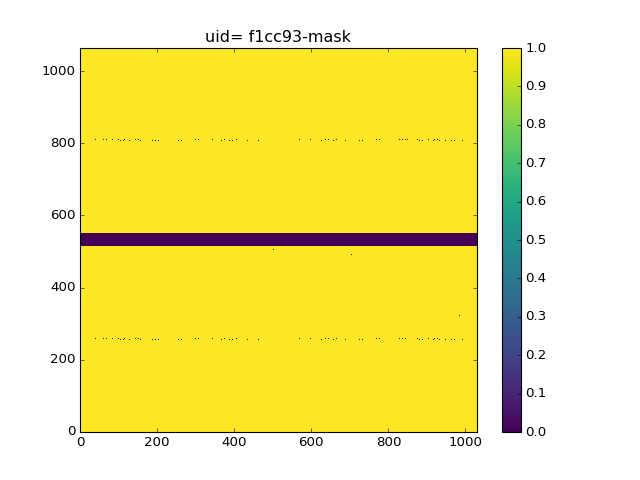

In [22]:
mask = load_mask(mask_path, mask_name, plot_ =  True, image_name = 'uid= %s-mask'%uid )
mask = np.array(mask, dtype = np.int32)

In [24]:
md['mask'] = mask
md['mask_file']= mask_path + mask_name 
md['NOTEBOOK_FULL_PATH'] = NOTEBOOK_FULL_PATH


In [25]:
maskr = mask[::-1,:]
imgsr = reverse_updown( imgs )
imgsra = apply_mask( imgsr, maskr )
imgsa = apply_mask( imgs, maskr )

In [27]:
#show_img( imgsa[0],  vmin=0.1, vmax=100, logs=True, image_name= 'uid= %s'%uid) 

In [28]:
#show_img( imgsa[0],  vmin= .01, vmax=50, logs= True, image_name= 'uid= %s'%uid) 

<IPython.core.display.Javascript object>


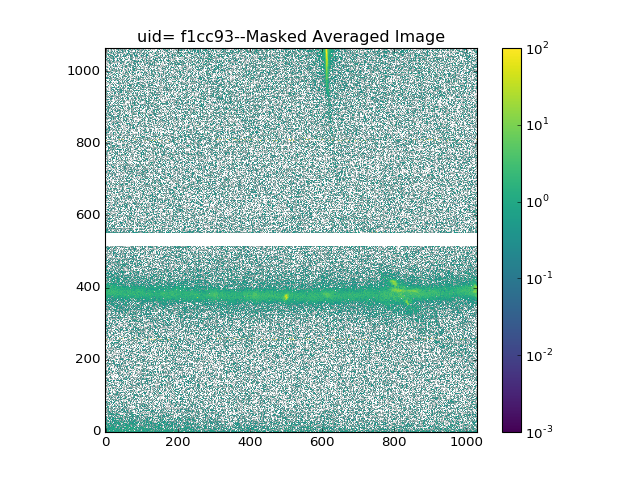

In [29]:
avg_img =  get_avg_img( imgsa, sampling = int(Nimg/3), plot_ = True, uid =uid)

In [ ]:
#show_img( avg_imgr,  vmin= 10, vmax=50, logs= True, image_name= 'uid= %s'%uid) 

## Determine Compress Or Not
* For sake of simplicity, we always compress data 

In [30]:
print (len( np.where(avg_img)[0] ) / ( imgsra[0].size))
compress =  len( np.where(avg_img)[0] ) / ( imgsra[0].size) < 1  #if the photon ocupation < 0.1, do compress

print (compress)
#compress = False

0.45962805961985503
True


## Compress Data
* Generate a compressed data with filename
* Replace old mask with a new mask with removed hot pixels
* Do average image
* Do each image sum
* Find badframe_list for where image sum above bad_pixel_threshold
* Check shutter open frame to get good time series


In [31]:
good_start = 0  #make the good_start at least 2

Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_f1cc9312-2360-47b2-af27-83792c554928-used.cmp.
Using a multiprocess to compress the data.
It will create 216 temporary files for parallel compression.


100%|██████████| 216/216 [40:11<00:00, 16.82s/it]


No bad frames are involved.
The good_start frame number is: 0 


<IPython.core.display.Javascript object>


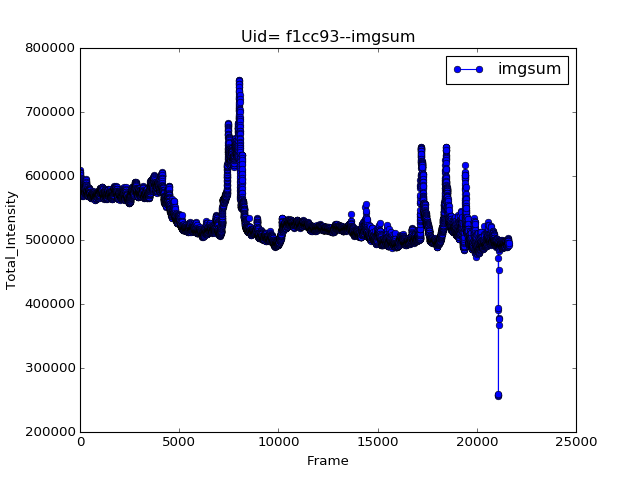

In [32]:
if True:
    if compress:
        filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s-used.cmp'%sud[1]
        mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
                                    force_compress= False, bad_pixel_threshold= 1e14,nobytes=4,
                                            para_compress=True, num_sub= 3000)    

        min_inten = 10    
        good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )    
        print ('The good_start frame number is: %s '%good_start)

        FD = Multifile(filename, good_start, len(imgs))
        
        #FD = Multifile(filename, 10,100)

        plot1D( y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])],
               title ='Uid= %s--imgsum'%uid, xlabel='Frame', ylabel='Total_Intensity', legend='imgsum'   )
    

In [ ]:
#%system ls -lh {sud[2][0]+"*"}|tail -2 ; ls -lh {filename}

In [34]:
bad_pixel_threshold= 8.6e15  #if re-define a bad pixel threshold
bad_pixel_low_threshold= 7.5e5 #if re-define a bad pixel low threshold

In [35]:
if bad_pixel_threshold<1e14:
    mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
                    force_compress=False, bad_pixel_threshold= bad_pixel_threshold,
                bad_pixel_low_threshold=bad_pixel_low_threshold, nobytes=4)
    min_inten = 10
    good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )   
    
    print ('The good_start frame number is: %s '%good_start)

## Define a good time series by defining a good start and good end

In [36]:
if False:
        good_start =0  #0
        min_inten = 10
        good_start =  max(good_start, np.where( np.array(imgsum) > min_inten )[0][0])    
        good_end =     len(imgsr)
        filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%sud[1] 
        FD = Multifile(filename, good_start, good_end)
        avg_img= get_avg_imgc( FD,  beg= None,end=None, plot_=False )
        imgsum,bad_frame_list = get_each_frame_intensityc( FD, bad_pixel_threshold= bad_pixel_threshold,
                    bad_pixel_low_threshold=bad_pixel_low_threshold, plot_=False )                           


In [37]:
if not compress:   
    #sampling = 1   #sampling should be one    
    sampling = 100  #sampling should be one     
    
    good_start = check_shutter_open( imgsra,  min_inten=5, time_edge = [0,10], plot_ = False )
    print ('The good_start frame number is: %s '%good_start)
    good_series = max(good_start, apply_mask( imgsra[good_start:], maskr ))
    avg_imgr =  get_avg_img( good_series, sampling = sampling, plot_ = False, uid =uid)
    imgsum, bad_frame_list = get_each_frame_intensity(good_series ,sampling = sampling, 
                                bad_pixel_threshold=1.2e8,  plot_ = False, uid=uid)
    
    

In [38]:
#print ('The bad frame list is: %s'% bad_frame_list)
print ('The number of bad frames is : %s '%len(bad_frame_list))
print ('The good_start frame number is: %s '%good_start)
md['good_start'] = good_start
md['bad_frame_list'] = bad_frame_list

The number of bad frames is : 0 
The good_start frame number is: 0 


In [39]:
imgsum_y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])]
imgsum_x = np.arange( len( imgsum_y))
save_lists(  [imgsum_x, imgsum_y], label=['Frame', 'Total_Intensity'], filename='uid=%s-imgsum'%uid, path= data_dir  )
           

<IPython.core.display.Javascript object>


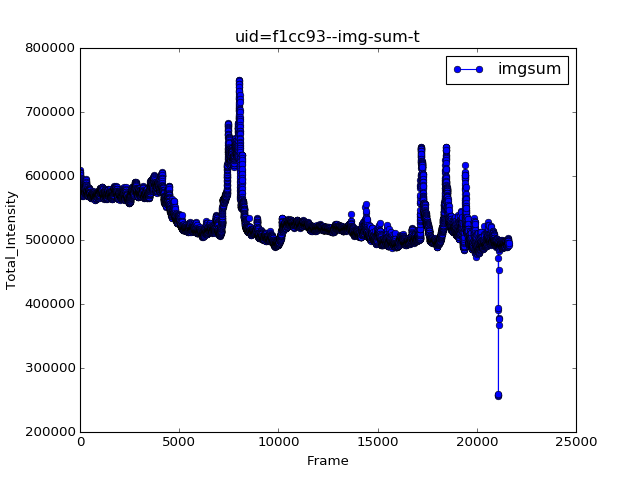

In [40]:
plot1D( y = imgsum_y, title ='uid=%s--img-sum-t'%uid, xlabel='Frame',
       ylabel='Total_Intensity', legend='imgsum', save=True, path=data_dir)

## Plot intensity average image

<IPython.core.display.Javascript object>


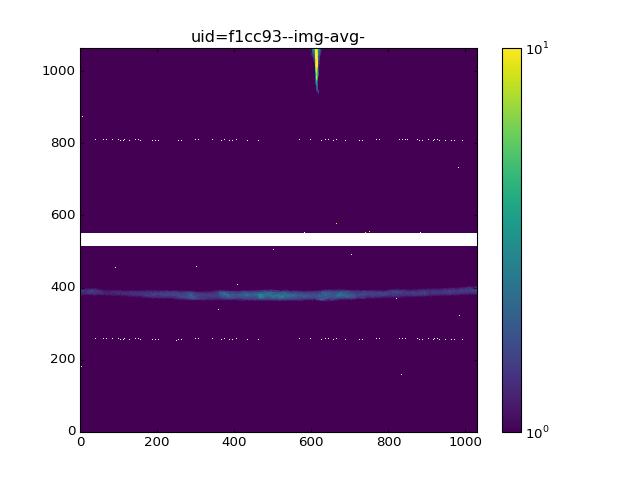

In [41]:
#avg_img = get_avg_imgc( FD,  beg=0,end=10000,sampling = 1, plot_ = False )
show_img( avg_img,  vmin=1.0, vmax= 10.0, logs=True, image_name= 'uid=%s--img-avg-'%uid,
        save=True, path=data_dir) 
md['avg_img'] = avg_img

# Create box-shaped ROI

In [42]:
from skimage.draw import line_aa, line, polygon

# For many boxes

In [43]:
if False:
    box_mask = np.zeros_like( avg_img , dtype = np.int32)
    wx,wy = [20,10]  #each box width and height

    cx = np.int_(np.linspace( 20, 920, 10))  #box center-x
    nx = len(cx)//2
    cy1 = np.linspace( 585, 600, nx)
    cy2 = np.linspace( 600, 585, nx)
    cy = np.int_( np.concatenate( [cy1, cy2] ) )  #box-center y

    for i, [cx_,cy_] in enumerate(list( zip( cx,cy  ))):  #create boxes
        x = np.array( [ cx_-wx, cx_+wx,  cx_+wx, cx_-wx])  
        y = np.array( [ cy_-wy, cy_-wy, cy_+wy, cy_+wy])
        rr, cc = polygon( y,x)
        #print( i + 1  )
        box_mask[rr,cc] = i +1
    box_mask = box_mask * mask    
    
    
    

In [44]:
if True:
    box_mask = np.zeros_like( avg_img , dtype = np.int32)
    wx,wy = [150,10]  #each box width and height

    
    cx, cy = [[170,500, 800], [375, 377, 381]] 
    
    for i, [cx_,cy_] in enumerate(list( zip( cx,cy  ))):  #create boxes
        x = np.array( [ cx_-wx, cx_+wx,  cx_+wx, cx_-wx])  
        y = np.array( [ cy_-wy, cy_-wy, cy_+wy, cy_+wy])
        rr, cc = polygon( y,x)
        #print( i + 1  )
        box_mask[rr,cc] = i +1
    box_mask = box_mask * mask  

# For one box

In [45]:
if False:
    box_mask = np.zeros_like( avg_img , dtype = np.int32)
    wx,wy = [400,10]  #each box width and height

    
    cx, cy = [[500], [377]] 
    
    for i, [cx_,cy_] in enumerate(list( zip( cx,cy  ))):  #create boxes
        x = np.array( [ cx_-wx, cx_+wx,  cx_+wx, cx_-wx])  
        y = np.array( [ cy_-wy, cy_-wy, cy_+wy, cy_+wy])
        rr, cc = polygon( y,x)
        #print( i + 1  )
        box_mask[rr,cc] = i +1
    box_mask = box_mask * mask  

In [46]:
#show_img( box_mask)

In [47]:
qr_center = cx
qz_center = [1]

In [48]:
#show_img( mask)

In [49]:
qind, pixelist = roi.extract_label_indices(box_mask)
noqs = len(np.unique(qind))

In [50]:
md['ring_mask'] = box_mask
md['qr_center']= qr_center
#md['qr_edge'] = qr_edge
md['qz_center']= qz_center
#md['qz_edge'] = qz_edge
md['beam_center_x'] = None #inc_x0
md['beam_center_y']=  None #inc_y0
md['refl_center_x'] = None #refl_x0
md['refl_center_y']=  None #refl_y0
md['incident angle'] = None #alphai*180/np.pi
md['data_dir'] = data_dir



psave_obj(  md, data_dir + 'uid=%s-md'%uid ) #save the setup parameters

In [51]:
badpixel = np.where( avg_img[:600,:] >=300 )

In [52]:
box_maskc = box_mask.copy()
box_mask[badpixel] =0

<IPython.core.display.Javascript object>


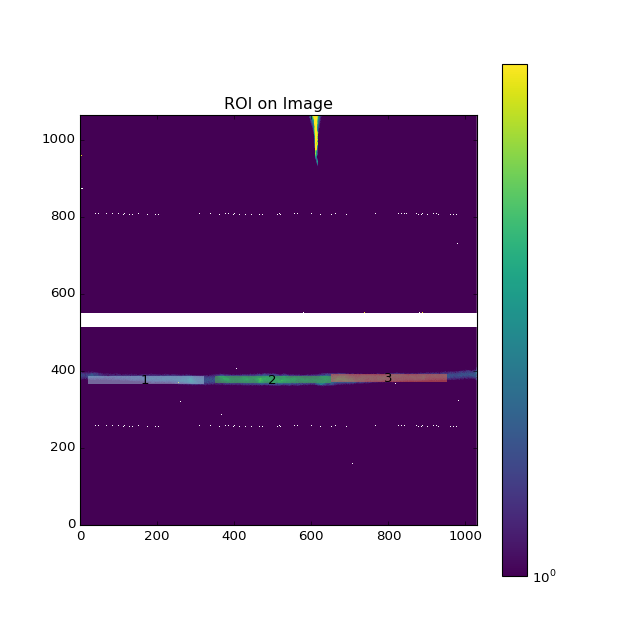

In [54]:
show_ROI_on_image( avg_img, box_mask, label_on = True,  alpha=.5,
                 save=True, path=data_dir, uid=uid, vmin=1, vmax=5)

* Number of pixels in each q box

In [55]:
nopr = np.bincount(qind, minlength=(noqs+1))[1:]
nopr

array([5997, 6000, 6000])

* Plot average image with interested Q-regions (boxes)

* Check one box intensity 

<IPython.core.display.Javascript object>


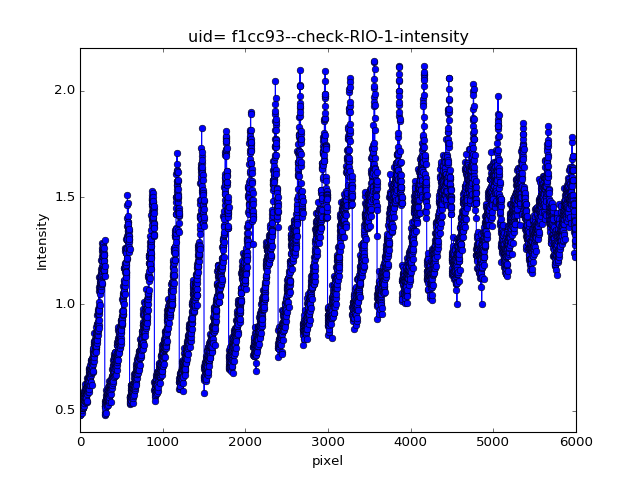

In [56]:
roi_inten = check_ROI_intensity( avg_img, box_mask, ring_number= 1, uid =uid )

## Check beam damage
* do a waterfall analysis

In [ ]:
if compress:
    qindex = 1
    wat = cal_waterfallc( FD, box_mask, qindex= qindex, save =True, path=data_dir, uid=uid)   
    

Get waterfall for q index=1:  10%|█         | 2248/21600 [00:16<02:18, 139.65it/s]

In [ ]:
if compress:
    plot_waterfallc( wat, qindex, aspect=None,  vmax= 15, vmin=0, uid=uid, save =True, 
                    path=data_dir, beg= FD.beg)

* check mean intensity of each box as a function of time

In [ ]:
if compress:
    times, mean_int_sets = get_each_ring_mean_intensityc(FD, box_mask,
                        timeperframe = None, plot_ = True, uid = uid , save=True, path=data_dir  )
    ring_avg = np.average( mean_int_sets, axis=0)
    
else:
    
    mean_int_sets = get_each_ring_mean_intensity(good_series, box_mask, sampling = sampling,
                                timeperframe = md['frame_time']*sampling, plot_ = True, uid = uid  )

In [ ]:
#plot1D( x= range( len(mean_int_sets)), y= mean_int_sets[:,1])

## One time Correlation

Note : Enter the number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/correlation.py

### if define another good_series

In [ ]:
if False:
    if compress:
        FD = Multifile(filename, good_start, len(imgs))
    else:
        good_start = 1
        good_end =  1000
        good_series = apply_mask( imgs[good_start:good_end-1], mask )

In [ ]:
lag_steps = None

In [ ]:
bad_frame_list

In [ ]:
para_cal = False  #True   #if True to use the parallel calculation

In [ ]:
import time

In [ ]:
t0 = time.time()
if compress:
    if para_cal:
        g2, lag_steps  =cal_g2p( FD,  box_mask, bad_frame_list, good_start, num_buf = 8, 
                        imgsum= None, norm=None )
    else:
        g2, lag_steps  =cal_g2c( FD,  box_mask, bad_frame_list, good_start, num_buf = 8, 
                        imgsum= None, norm=None )        
else:
    bad_image_process = False
    if  len(bad_frame_list):
        bad_image_process = True
    print( bad_image_process  )    

    g2, lag_steps  =cal_g2( good_series,  box_maskr, bad_image_process,
                       bad_frame_list, good_start, num_buf = 8 )
run_time(t0)

In [ ]:
lag_steps

In [ ]:
qr_center = [ '%s*X'%i for i in cx]
qz_center = [1]

In [ ]:
taus = lag_steps * timeperframe
res_pargs = dict(taus=taus, qz_center=qz_center, qr_center=qr_center,  path=data_dir, uid=uid )

In [ ]:
save_gisaxs_g2(  g2, res_pargs )

### Plot the one time correlation functions

In [ ]:
plot_gisaxs_g2( g2, taus,  vlim=[0.999, 1.001], res_pargs=res_pargs, one_plot=True)    

# Fit g2

In [ ]:
fit= True

In [ ]:
if fit:
    fit_result = fit_gisaxs_g2( g2, res_pargs, function = 'stretched',  vlim=[0.95, 1.1], 
                fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},
                guess_values={'baseline':1.229,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01},
                              one_plot= True)

In [ ]:
psave_obj( fit_result, data_dir + 'uid=%s-g2-fit-para'%uid )

# Plot the relaxation time versus qr for different qz

In [ ]:
if False:
    fit_qr_qz_rate(  qr_center, qz_center, fit_result, power_variable= False,
           uid=uid, path= data_dir )

# For two-time

In [ ]:
if compress:
    FD = Multifile(filename, 0, Nimg)

In [ ]:
run_two_time =  True

In [ ]:
para_cal = False #True 

In [ ]:
if run_two_time:
    
    if compress:
        norm = None
        data_pixel =   Get_Pixel_Arrayc( FD, pixelist,  norm=norm ).get_data()
        if para_cal:
            g12b = auto_two_Arrayp(  data_pixel,  box_mask, index = None   )    
        else:    
            g12b = auto_two_Arrayc(  data_pixel,  box_mask, index = None   ) 
           
        if lag_steps is None:
            num_bufs=8
            noframes = FD.end - FD.beg
            num_levels = int(np.log( noframes/(num_bufs-1))/np.log(2) +1) +1
            tot_channels, lag_steps, dict_lag = multi_tau_lags(num_levels, num_bufs)
            max_taus= lag_steps.max()
    else:
        qind, pixelist = roi.extract_label_indices(   box_maskr  )
        t0 = time.time()
        data_pixel =   Get_Pixel_Array( good_series , pixelist).get_data()
        run_time(t0)
        g12b = auto_two_Array( good_series, box_maskr, data_pixel = data_pixel ) 
        
        

In [ ]:
if run_two_time:
    show_C12(g12b, q_ind= 0, N1=0, N2=200, vmin=0.9, vmax=1.05,
             timeperframe=timeperframe,save=True, path= data_dir, uid = uid ) 

In [ ]:
import time

In [ ]:
if run_two_time:
    if lag_steps is None:
        num_bufs=8
        noframes = FD.end - FD.beg
        num_levels = int(np.log( noframes/(num_bufs-1))/np.log(2) +1) +1
        tot_channels, lag_steps, dict_lag = multi_tau_lags(num_levels, num_bufs)
        max_taus= lag_steps.max()
    
    max_taus= lag_steps.max()
    t0=time.time()
    g2b = get_one_time_from_two_time(g12b)[:max_taus]
    run_time(t0)
    taus2 = np.arange( g2b.shape[0])[:max_taus] *timeperframe

    res_pargs2 = dict(taus=taus2, qz_center=qz_center, qr_center=qr_center,
             path=data_dir, uid=uid + 'g2_from_two-time'        )        
    save_gisaxs_g2(  g2b, res_pargs2,  taus=np.arange( g2b.shape[0]) *timeperframe,
                 filename='g2_from_two-time')



In [ ]:
if run_two_time:
    plot_gisaxs_two_g2( g2, taus, 
                 g2b, np.arange( g2b.shape[0]) *timeperframe,
                 res_pargs=res_pargs, vlim=[.999, 1.001],one_plot= True, uid =uid )

# Four Time Correlation

In [ ]:
run_four_time = False

In [ ]:
if run_four_time:
    t0=time.time()
    g4 = get_four_time_from_two_time(g12b, g2=g2b)[:max_taus]
    run_time(t0)

In [ ]:
if run_four_time:
    taus4 = np.arange( g4.shape[0])*timeperframe
    res_pargs4 = dict(taus=taus4, qz_center=qz_center, qr_center=qr_center, path=data_dir, uid=uid )
    save_gisaxs_g2(   g4,  res_pargs4,   filename='uid=%s--g4.csv' % (uid) )

In [ ]:
 if run_four_time:
        plot_gisaxs_g4( g4, taus4,  vlim=[0.95, 1.05], res_pargs=res_pargs, one_plot= True)  

# Create a PDF report

In [ ]:
create_report = True

In [ ]:
pdf_out_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

In [ ]:
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/XPCS_GiSAXS.py
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/Create_Report.py

In [ ]:
if create_report:
    c= create_pdf_report(  data_dir, uid, pdf_out_dir,
                    filename= "XPCS_Analysis_Report_for_uid=%s_Cubes.pdf"%uid, report_type='gisaxs')
    
    #Page one: Meta-data/Iq-Q/ROI
    c.report_header(page=1)
    c.report_meta( top=730)
    c.report_static( top=560, iq_fit =None )
    c.report_ROI( top= 300)
    
    #Page Two: img~t/iq~t/waterfall/mean~t/g2/rate~q
    c.new_page()
    c.report_header(page=2)
    c.report_time_analysis( top= 720)
    c.report_one_time( top= 350)  
    
    #Page Three: two-time/two g2
    if run_two_time:
        c.new_page()
        c.report_header(page=3)
        c.report_two_time(  top= 720 )      

    if run_four_time:
        c.new_page()
        c.report_header(page=4)
        c.report_four_time(  top= 720 ) 
        
        
    c.save_page()
    c.done()        


# The End!

## Attach the PDF report to Olog 

In [ ]:
from chxanalys.chx_olog import LogEntry,Attachment, update_olog_uid, update_olog_id

In [ ]:
os.environ['HTTPS_PROXY'] = 'https://proxy:8888'
os.environ['no_proxy'] = 'cs.nsls2.local,localhost,127.0.0.1'

In [ ]:
c.filename

In [ ]:
filename = c.filename
atch=[  Attachment(open(filename, 'rb')) ] 

update_olog_uid( uid=uid, text='Add XPCS Analysis PDF Report', attachments= atch )

## Attach the Analysis Notebook to Olog 

In [ ]:
#NOTEBOOK_FULL_PATH

In [ ]:
#note_path = '2016_2/yuzhang/August/XPCS_GiSAXS_Single_Run_Sep.ipynb'

In [ ]:
#filename = '/XF11ID/analysis/'+ note_path #NOTEBOOK_FULL_PATH

#atch=[  Attachment(open(filename, 'rb')) ] 
#update_olog_uid( uid=uid, text='Add XPCS Analysis notebook', attachments= atch )